In [3]:
import pandas as pd
import numpy as np
import numpy.linalg as nla
import numpy.random as nrd
import matplotlib.pyplot as plt

from csaps import CubicSmoothingSpline
from scipy.integrate import quad

# Exercise 8.6

Consider the bone mineral density data of Figure 5.6.

    (a) Fit a cubic smooth spline to the relative change in spinal BMD, as a function of age. Use cross-validation to estimate the optimal amount of smoothing. Construct pointwise 90% confidence bands for the underlying function.

    (b) Compute the posterior mean and covariance for the true function via (8.28), and compare the posterior bands to those obtained in (a).

    (c) Compute 100 bootstrap replicates of the fitted curves, as in the bottom left panel of Figure 8.2. Compare the results to those obtained in (a) and (b).

# Solution

Some useful functions for the notebook,

In [4]:
def sort_wrt_X(X,y):
    
    full_set = sorted(zip(X,y),key=lambda el:el[0])
        
    X_sort = []
    y_sort = []
    for x0,y0 in full_set:
        X_sort.append(x0)
        y_sort.append(y0)
        
    return np.array(X_sort), np.array(y_sort)

def cv_splitting(X,y,n):
    
    N = len(X)
    delta = N//n
    
    splitting = []
    
    for i in range(n):
        X_train = np.concatenate((X[:i*delta],X[(i+1)*delta:]))
        y_train = np.concatenate((y[:i*delta],y[(i+1)*delta:]))        
        X_train, y_train = sort_wrt_X(X_train,y_train)

        X_cv = X[i*delta:(i+1)*delta]
        y_cv = y[i*delta:(i+1)*delta]
        X_cv, y_cv = sort_wrt_X(X_cv,y_cv)
            
        splitting.append([X_train,y_train,X_cv,y_cv])
        
    return splitting

def error_spline(X,y,spl):
    y_exp = spl(X)
    res = (y - y_exp)**2
    return np.mean(res)

def K_fold_cross_validation_spline(X,y,K,lamb_list):
    train_error = []
    cv_error = []
    cv_sigma = []

    for lamb in lamb_list:

        err_train = []
        err_cv = []

        for X_train,y_train,X_cv,y_cv in cv_splitting(X,y,K):
            spl = CubicSmoothingSpline(X_train, y_train, smooth=lamb)
            err_train.append(error_spline(X_train, y_train,spl))
            err_cv.append(error_spline(X_cv,y_cv,spl))

        train_error.append(np.mean(err_train))
        cv_error.append(np.mean(err_cv))
        cv_sigma.append(np.std(err_cv)/np.sqrt(K))

    return train_error, cv_error, cv_sigma

def cubic_splines_basis(knots):
    
    n = len(knots)
    basis = {}
    deriv2 = {}
    
    knot_K = knots[-1]
    knot_K1 = knots[-2]
    
    def d0(x,knot):
        return (max((0,(x-knot)**3)) - max((0,(x-knot_K)**3)))/(knot_K-knot)
    
    def d2(x,knot):
        return 6*(max((0,x-knot)) - max((0,x-knot_K)))/(knot_K-knot)
    
    def d_factory(d,knot):
        return lambda x : d(x,knot) - d(x,knot_K1)
    
    basis[0] = lambda x : 1
    deriv2[0] = lambda x : 0
    
    basis[1] = lambda x : x
    deriv2[1] = lambda x : 0
    
    for k,knot in enumerate(knots[:-2]):
        basis[k+2] = d_factory(d0,knot)
        deriv2[k+2] = d_factory(d2,knot)
        
    return basis,deriv2

def cubic_spline_matrix(X):
    
    n = len(X)
    a = X[0]
    b = X[-1]
    basis,deriv2 = cubic_splines_basis(X)
    
    N = np.array([[basis[j](x) for j in range(n)] for x in X])
    
    omega_N = np.zeros((n,n))
    
    for i in range(n):
        for j in range(n):
            entry,_ = quad(lambda t : deriv2[i](t)*deriv2[j](t),a,b)
            omega_N[i,j] = entry
            omega_N[j,i] = entry
            
    return N, omega_N

def select_bootstrap_set(X,y,eps=0):
    
    N = X.size
    indices_in = nrd.choice(N, size=N, replace=True)
    
    X_bs = X[indices_in]
    X_bs += eps*nrd.rand(N) # This is to avoid degeneracy
    y_bs = y[indices_in]
    
    X_bs,y_bs = sort_wrt_X(X_bs,y_bs)
    
    return X_bs, y_bs

In [5]:
url_bones = 'https://web.stanford.edu/~hastie/ElemStatLearn/datasets/bone.data'
df_bones = pd.read_csv(url_bones,sep='\t')

df_bones.tail()

,idnum,age,gender,spnbmd
480,380,11.6,male,0.116368
481,381,9.8,female,0.097902
482,382,11.9,male,0.028986
483,383,11.2,male,-0.064103
484,384,9.8,female,0.049908


In [6]:
df_bones_male = df_bones[df_bones['gender']=='male']
df_bones_female = df_bones[df_bones['gender']=='female']

y_male = df_bones_male['spnbmd'].to_numpy()
X_male = df_bones_male['age'].to_numpy()

y_female = df_bones_female['spnbmd'].to_numpy()
X_female = df_bones_female['age'].to_numpy()

# The package we use for the cubic smooth spline needs X to be non-degenerate
eps = 0.001
X_male += eps*nrd.rand(X_male.size)
X_female += eps*nrd.rand(X_female.size)

## Cross-Validation to select the amount of smoothing

### Male

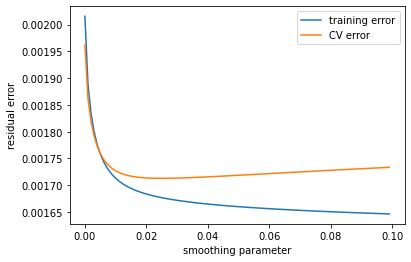

lambda = 0.025 gives minimum CV error = 0.00171


In [12]:
lamb_list = np.arange(0,0.1,0.001)
K = 5

train_error, cv_error, cv_se = K_fold_cross_validation_spline(X_male,y_male,K,lamb_list)

plt.plot(lamb_list,train_error,label='training error')
plt.plot(lamb_list,cv_error,label='CV error')
plt.xlabel('smoothing parameter')
plt.ylabel('residual error')
plt.legend()
plt.show()

i_min = np.argmin(cv_error)
opt_lamb_male = lamb_list[i_min]
print('lambda = {:.3f} gives minimum CV error = {:.5f}'.format(opt_lamb_male,cv_error[i_min]))

X_male_srt, y_male_srt = sort_wrt_X(X_male,y_male)

opt_spl_male = CubicSmoothingSpline(X_male_srt, y_male_srt, smooth=opt_lamb_male)

To compute the confidence bars, we need the $N$ and $\Omega_N$ matrix,

In [6]:
N_male,omega_male = cubic_spline_matrix(X_male_srt)

Here we check that indeed the two methods are equivalent

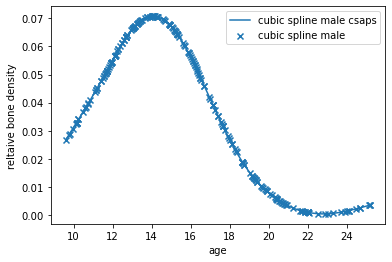

In [7]:
# Move from the csaps smoothing factor to the one on the book
opt_smooth_male = (1-opt_lamb_male)/opt_lamb_male

W = nla.pinv(N_male.T @ N_male + opt_smooth_male * omega_male)
beta_male = W @ N_male.T @ y_male_srt
f_male = N_male @ beta_male

plt.plot(X_male_srt,opt_spl_male(X_male_srt),label='cubic spline male csaps')
plt.scatter(X_male_srt,f_male,marker='x',label='cubic spline male')
plt.xlabel('age')
plt.ylabel('reltaive bone density')
plt.legend()
plt.show()

To get the confidence bands we need,

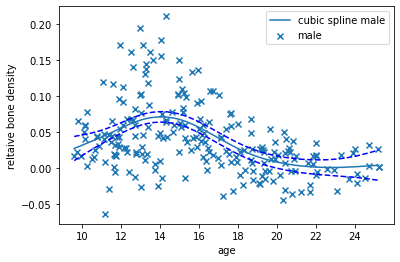

In [8]:
# First we estimate the noise
sigma_noise = error_spline(X_male_srt, y_male_srt,opt_spl_male)

# The the covariance matrix for the fitting coefficients,
cov_beta = W @ N_male.T @ N_male @ W * sigma_noise

# From the covariance matrix, we can get the standard error at each x0,
std_err = []
for n0 in N_male:
    std_err.append(np.sqrt(n0 @ cov_beta @ n0))
std_err = np.array(std_err)

# the 90% confidence bands are
f_male_min = f_male - 1.645 * std_err
f_male_plus = f_male + 1.645 * std_err

plt.scatter(X_male,y_male,marker='x',label='male')
plt.plot(X_male_srt,f_male,label='cubic spline male')
plt.plot(X_male_srt,f_male_min,'--',c='b')
plt.plot(X_male_srt,f_male_plus,'--',c='b')
plt.xlabel('age')
plt.ylabel('reltaive bone density')
plt.legend()
plt.show()

### Bayesian methods

Here we use the relations given in eq 2.28 of the book, with the difference that our splines are smoothed.

These require the assumption of an additive error model, where the error is Gaussian distributed (same as we assumed above), and that the prior of the beta parameter is Gaussian.

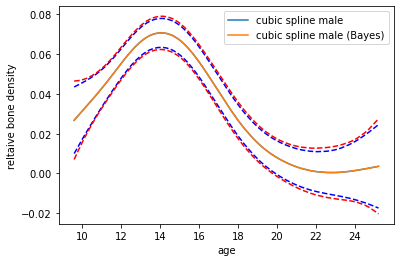

In [9]:
tau = 100 # non-informative prior

# The mean value and covariance for beta (from posterior distribution)
n = len(X_male_srt)
Id = np.eye(n)
W_bayes = nla.pinv(N_male.T@N_male+opt_smooth_male*omega_male+sigma_noise/tau*Id)

beta_mean_bayes = W_bayes @ N_male.T @ y_male_srt
beta_cov_bayes = W_bayes * sigma_noise

# The mean value and std error for the spline
mean_bayes = []
std_err_bayes = []
for n0 in N_male:
    mean_bayes.append(n0 @ beta_mean_bayes)
    std_err_bayes.append(np.sqrt(n0 @ beta_cov_bayes @ n0))
    
mean_bayes = np.array(mean_bayes)
std_err_bayes = np.array(std_err_bayes)

# Bayes confidence bands
f_bayes_min = mean_bayes - 1.645 * std_err_bayes
f_bayes_plus = mean_bayes + 1.645 * std_err_bayes


# Let's compare the spline and confidence bands,
plt.plot(X_male_srt,f_male,label='cubic spline male')
plt.plot(X_male_srt,mean_bayes,label='cubic spline male (Bayes)')
plt.plot(X_male_srt,f_male_min,'--',c='b')
plt.plot(X_male_srt,f_male_plus,'--',c='b')
plt.plot(X_male_srt,f_bayes_min,'--',c='r')
plt.plot(X_male_srt,f_bayes_plus,'--',c='r')
plt.xlabel('age')
plt.ylabel('reltaive bone density')
plt.legend()
plt.show()

### Bootstrap methods

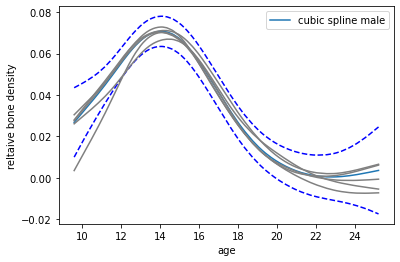

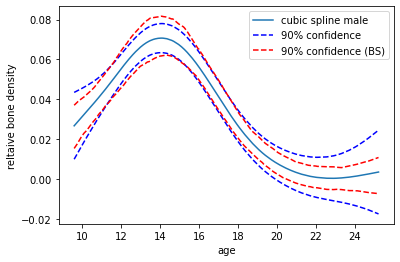

In [21]:
B = 200 # Number of bootstrap sets
bootstrap_replicates = []

for b in range(B):
    X_bs,y_bt = select_bootstrap_set(X_male_srt,y_male_srt,eps=0.001)
    spl = CubicSmoothingSpline(X_bs,y_bt, smooth=opt_lamb_male)
    bootstrap_replicates.append(spl(X_male_srt))
    
bootstrap_replicates = np.array(bootstrap_replicates)

# Let's visualize a small sample
plt.plot(X_male_srt,f_male,label='cubic spline male')
plt.plot(X_male_srt,f_male_min,'--',c='b')
plt.plot(X_male_srt,f_male_plus,'--',c='b')
plt.xlabel('age')
plt.ylabel('reltaive bone density')
plt.legend()

for i in range(5):
    f_bs = bootstrap_replicates[i]
    plt.plot(X_male_srt,f_bs,c='gray')
    
plt.show()
    
# The 90% confidence interval
f_bs_min = []
f_bs_plus = []

for f0_bs in bootstrap_replicates.T:
    sorted_f0_bs = np.sort(f0_bs)
    f_bs_min.append(sorted_f0_bs[-10])
    f_bs_plus.append(sorted_f0_bs[10])

plt.plot(X_male_srt,f_male,label='cubic spline male')
plt.plot(X_male_srt,f_male_min,'--',c='b',label='90% confidence')
plt.plot(X_male_srt,f_male_plus,'--',c='b')
plt.plot(X_male_srt,f_bs_min,'--',c='r',label='90% confidence (BS)')
plt.plot(X_male_srt,f_bs_plus,'--',c='r')
plt.xlabel('age')
plt.ylabel('reltaive bone density')
plt.legend()
plt.show()

### Female

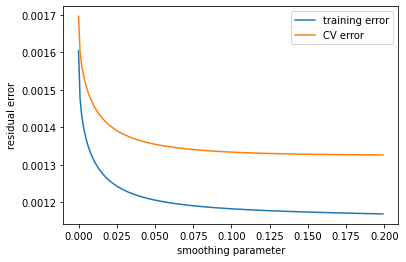

lambda = 0.025 gives minimum CV error = 0.00133


In [7]:
lamb_list = np.arange(0,0.2,0.001)
K = 5

train_error, cv_error, cv_sigma = K_fold_cross_validation_spline(X_female,y_female,K,lamb_list)

plt.plot(lamb_list,train_error,label='training error')
plt.plot(lamb_list,cv_error,label='CV error')
plt.xlabel('smoothing parameter')
plt.ylabel('residual error')
plt.legend()
plt.show()

i_min = np.argmin(cv_error)
opt_lamb_female = lamb_list[i_min]
print('lambda = {:.3f} gives minimum CV error = {:.5f}'.format(opt_lamb_male,cv_error[i_min]))

X_female_srt, y_female_srt = sort_wrt_X(X_female,y_female)

opt_spl_female = CubicSmoothingSpline(X_female_srt, y_female_srt, smooth=opt_lamb_female)

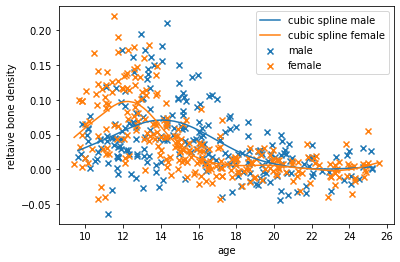

In [8]:
plt.scatter(X_male,y_male,marker='x',label='male')
plt.plot(X_male_srt,opt_spl_male(X_male_srt),label='cubic spline male')
plt.scatter(X_female,y_female,marker='x',label='female')
plt.plot(X_female_srt,opt_spl_female(X_female_srt),label='cubic spline female')
plt.xlabel('age')
plt.ylabel('reltaive bone density')
plt.legend()
plt.show()